This notebook roughly follows [Detecting opinion spams and fake news ... (2017)](https://www.researchgate.net/publication/322128415_Detecting_opinion_spams_and_fake_news_using_text_classification) by copy-pasting some code from CodeBasic's [videos](https://www.youtube.com/playlist?list=PLeo1K3hjS3uuvuAXhYjV2lMEShq2UYSwX) and [notebooks](https://github.com/codebasics/nlp-tutorials/blob/main/11_bag_of_n_grams/10_bag_of_n_grams.ipynb).

<div style="color:red;">Please download the Kaggle dataset and LIAR dataset first.</div>

# Read in datasets

In [74]:
import pandas as pd
import matplotlib.pyplot as plt

In [41]:
# Read in LIAR dataset columns 1 and 2 only:
liar_df = pd.read_csv('./Datasets/liar_dataset/train.tsv', sep='\t')

liar_df.head()

,2635.json,false,Says the Annies List political group supports third-trimester abortions on demand.,abortion,dwayne-bohac,State representative,Texas,republican,0,1,0.1,0.2,0.3,a mailer
0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
2,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
3,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
4,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece


In [44]:
# Reducing columns for the liar dataset:
condensed_liar[['Label','Statement']] = liar_df.iloc[: , [1, 2]].copy()
 

condensed_liar['Truth'] = condensed_liar.Label.map({
     'pants-fire': 0,
     'false': 0,
     'mostly-false': 0,
     'half-true': 0,
     'barely-true': 1,
     'mostly-true': 1,
     'true': 1
})
condensed_liar.head()

,Label,Statement,Truth
0,half-true,When did the decline of coal start? It started...,0
1,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",1
2,false,Health care reform legislation is likely to ma...,0
3,half-true,The economic turnaround started at the end of ...,0
4,true,The Chicago Bears have had more starting quart...,1


In [17]:
# Read in Kaggle titles only. The dataframe df_kaggle has two columns: article titles, and (true/false).
news_df = pd.read_csv('./Datasets/fake-news/train.csv',index_col=0)
#kaggle_df = pd.concat([kaggle_df_true, kaggle_df_fake], ignore_index=True, sort=False)
news_df.head()

,title,author,text,label
id,,,,
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


# Extracting grammatical error 

We are goint to use some of the packages listed here: https://blog.sapling.ai/python-spelling-and-grammar-checkers/ 

In [45]:
from sapling import SaplingClient
api_key = 'XN4G2E8BOIJEDKTF6QQTYVWJHGZRZSPD'
client = SaplingClient(api_key=api_key)

In [58]:
#news_df['Gram_Errors'] = [len(client.edits(x, session_id='test_session')) for x in news_df['title']]
#news_df['Gram_Errors']
gram_errors = []
for x in news_df['title']:
    gram_errors.append(len(client.edits(x, session_id='test_session2')))

print(gram_errors)
#gram_errors = [len(client.edits(x, session_id='test_session')) for x in news_df['title']]

Exception: HTTP 429: {"key_prefix":"XN4********************************","msg":"Rate Limited. Visit https://sapling.ai/docs/api/api-access for details."}


In [59]:
import language_tool_python #python wraper for language_tool_python: https://pypi.org/project/language-tool-python/
tool = language_tool_python.LanguageToolPublicAPI('en-US') # or use public API

In [85]:
news_shortened = news_df.iloc[:50,:]


In [86]:
news_shortened['Gram_Errors'] = [len(tool.check(x)) for x in news_shortened['title']]

C:\Users\elros\AppData\Local\Temp\ipykernel_21252\3518040429.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_shortened['Gram_Errors'] = [len(tool.check(x)) for x in news_shortened['title']]


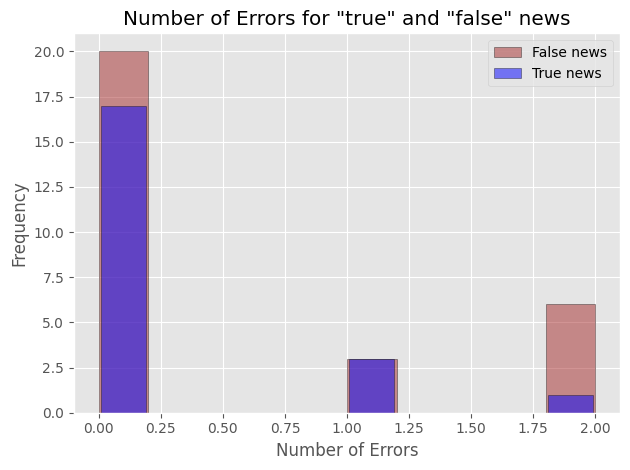

In [87]:
true = news_shortened['label']  == 1
false = news_shortened['label']  == 0
plt.style.use('ggplot')
 
plt.title('Number of Errors for "true" and "false" news')
 
plt.hist(news_shortened['Gram_Errors'][false], edgecolor='black',color='brown',rwidth=1.1,alpha=0.5,label='False news')
plt.hist(news_shortened['Gram_Errors'][true], edgecolor='black',color='blue',rwidth=0.9,alpha=0.5,label='True news')
 
plt.legend(loc='upper right')
 
plt.xlabel('Number of Errors')
plt.ylabel('Frequency')
 
plt.tight_layout()
 
plt.show()

In [67]:
gram_errors = []
for x in news_shortened['title']:
    gram_errors.append(len(tool.check(x)))

print(gram_errors)

news_shortened['gram_errors'] = gram_errors


[2, 0, 0, 0, 0, 0, 0, 2, 1, 0]


C:\Users\elros\AppData\Local\Temp\ipykernel_21252\2419556749.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_shortened['gram_errors'] = gram_errors


# Preprocessing

<div style="color:red;">You may need to install</div> [`spacy`](https://spacy.io/usage/). For instance, in `conda powershell`, type the following two commands:
```
conda install -c conda-forge spacy
python -m spacy download en_core_web_sm
```

In [55]:
import spacy

# load english language model and create nlp object from it
nlp = spacy.load("en_core_web_sm") 

def preprocess(text):
    # remove stop words and lemmatize the text
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)
    
    return " ".join(filtered_tokens)

In [56]:
# preprocess kaggle_corpus
kaggle_corpus = kaggle_df.loc[:,'title'].tolist()
kaggle_corpus_processed = [preprocess(text) for text in kaggle_corpus]

In [64]:
# preprocess liar_corpus
liar_corpus = liar_df.loc[:,'Statement'].tolist()
liar_corpus_processed = [preprocess(text) for text in liar_corpus]

# Train-test split

In [65]:
from sklearn.model_selection import train_test_split

kaggle_X_train, kaggle_X_test, kaggle_y_train, kaggle_y_test = train_test_split(
    kaggle_corpus_processed, 
    kaggle_df.Truth, 
    test_size=0.2, # 20% samples will go to test dataset
    random_state=2022,
    stratify=kaggle_df.Truth
)

liar_X_train, liar_X_test, liar_y_train, liar_y_test = train_test_split(
    liar_corpus_processed, 
    liar_df.Truth, 
    test_size=0.2, # 20% samples will go to test dataset
    random_state=2022,
    stratify=None
)